In [1]:
#!/usr/bin/env python 

'''
-Initially make z_to_x and x_to_z fairly shallow networks.  Inject noise?  

-Use the fflayer class?  

'''
import sys

sys.setrecursionlimit(100000)
sys.path.append("/u/lambalex/DeepLearning/undirected_matching")
sys.path.append("/u/lambalex/DeepLearning/undirected_matching/lib")

import theano
import theano.tensor as T
from nn_layers import fflayer, param_init_fflayer, param_init_convlayer, convlayer
from utils import init_tparams, join2, srng, dropout, inverse_sigmoid, join3, merge_images
from loss import accuracy, crossent, lsgan_loss, wgan_loss, improvement_loss
import lasagne
import numpy as np
import numpy.random as rng
import gzip
import cPickle as pickle
import random
from viz import plot_images
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn import svm

import os
slurm_name = os.environ["SLURM_JOB_ID"]

class ConsiderConstant(theano.compile.ViewOp):
    def grad(self, args, g_outs):
        return [T.zeros_like(g_out) for g_out in g_outs]

consider_constant = ConsiderConstant()



def init_gparams(p):

    p = param_init_fflayer(options={},params=p,prefix='z_x_1',nin=nl*2,nout=512*4*4,ortho=False,batch_norm=True)

    p = param_init_convlayer(options={},params=p,prefix='z_x_2',nin=512,nout=256,kernel_len=5,batch_norm=True)
    p = param_init_convlayer(options={},params=p,prefix='z_x_3',nin=256*1,nout=128,kernel_len=5,batch_norm=True)
    p = param_init_convlayer(options={},params=p,prefix='z_x_4',nin=128*1,nout=3,kernel_len=5,batch_norm=False)

    p = param_init_convlayer(options={},params=p,prefix='x_z_1',nin=3,nout=32,kernel_len=5,batch_norm=True)
    p = param_init_convlayer(options={},params=p,prefix='x_z_2',nin=32,nout=64,kernel_len=5,batch_norm=True)
    p = param_init_convlayer(options={},params=p,prefix='x_z_3',nin=64,nout=128,kernel_len=5,batch_norm=True)
    p = param_init_convlayer(options={},params=p,prefix='x_z_4',nin=128,nout=256,kernel_len=5,batch_norm=True)
    p = param_init_convlayer(options={},params=p,prefix='x_z_5',nin=256,nout=512,kernel_len=5,batch_norm=True)

    p = param_init_fflayer(options={},params=p,prefix='x_z_fc1',nin=512*4*4,nout=1024,ortho=False,batch_norm=True)
    p = param_init_fflayer(options={},params=p,prefix='x_z_fc2',nin=1024,nout=1024,ortho=False,batch_norm=True)

    p = param_init_fflayer(options={},params=p,prefix='x_z_mu',nin=1024,nout=nl,ortho=False,batch_norm=False)
    p = param_init_fflayer(options={},params=p,prefix='x_z_sigma',nin=1024,nout=nl,ortho=False,batch_norm=False)

    return init_tparams(p)

def init_cparams(p):

    p = param_init_fflayer(options={},params=p,prefix='c_1',nin=nl+512*4*4,nout=512,ortho=False,batch_norm=True)
    print "mlp on top, 512 dim"
    p = param_init_fflayer(options={},params=p,prefix='c_2',nin=512,nout=512,ortho=False,batch_norm=True)
    p = param_init_fflayer(options={},params=p,prefix='c_3',nin=512,nout=10,ortho=False,batch_norm=False)

    return init_tparams(p)

def init_dparams(p):

    print "NOT trying batch norm in the discriminator part that sees x!"
    p = param_init_convlayer(options={},params=p,prefix='DC_1',nin=3,nout=32,kernel_len=5,batch_norm=False)
    p = param_init_convlayer(options={},params=p,prefix='DC_2',nin=32,nout=64,kernel_len=5,batch_norm=False)
    p = param_init_convlayer(options={},params=p,prefix='DC_3',nin=64,nout=128,kernel_len=5,batch_norm=False)
    p = param_init_convlayer(options={},params=p,prefix='DC_4',nin=128,nout=256,kernel_len=5,batch_norm=False)
    p = param_init_convlayer(options={},params=p,prefix='DC_5',nin=256,nout=512,kernel_len=5,batch_norm=False)

    p = param_init_fflayer(options={},params=p,prefix='D_1',nin=nl+512*4*4,nout=nfd,ortho=False,batch_norm=False)
    p = param_init_fflayer(options={},params=p,prefix='D_2',nin=nfd,nout=nfd,ortho=False,batch_norm=False)
    p = param_init_fflayer(options={},params=p,prefix='D_3',nin=nfd,nout=nfd,ortho=False,batch_norm=False)

    p = param_init_fflayer(options={},params=p,prefix='D_o_1',nin=nfd,nout=1,ortho=False,batch_norm=False)
    p = param_init_fflayer(options={},params=p,prefix='D_o_2',nin=nfd,nout=1,ortho=False,batch_norm=False)
    p = param_init_fflayer(options={},params=p,prefix='D_o_3',nin=nfd,nout=1,ortho=False,batch_norm=False)

    p = param_init_convlayer(options={},params=p,prefix='D_o_4',nin=128,nout=1,kernel_len=5,batch_norm=False)
    p = param_init_convlayer(options={},params=p,prefix='D_o_5',nin=256,nout=1,kernel_len=5,batch_norm=False)
    p = param_init_convlayer(options={},params=p,prefix='D_o_6',nin=512,nout=1,kernel_len=5,batch_norm=False)

    return init_tparams(p)


def z_to_x(p,z):

    print "no extra noise input"
    z_inp = join2(z, 0.0*srng.normal(size=z.shape))

    d0 = fflayer(tparams=p,state_below=z_inp,options={},prefix='z_x_1',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)')

    d0 = d0.reshape((64,512,4,4))

    d1 = convlayer(tparams=p,state_below=d0,options={},prefix='z_x_2',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=-2)

    d2 = convlayer(tparams=p,state_below=d1,options={},prefix='z_x_3',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=-2)

    d3 = convlayer(tparams=p,state_below=d2,options={},prefix='z_x_4',activ='lambda x: x',stride=-2)

    x_new = d3.flatten(2)

    return x_new

def x_to_z(p,x):

    e1 = convlayer(tparams=p,state_below=x.reshape((64,3,32,32)),options={},prefix='x_z_1',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=1)

    e2 = convlayer(tparams=p,state_below=e1,options={},prefix='x_z_2',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=2)

    e3 = convlayer(tparams=p,state_below=e2,options={},prefix='x_z_3',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=1)

    e4 = convlayer(tparams=p,state_below=e3,options={},prefix='x_z_4',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=2)

    e5 = convlayer(tparams=p,state_below=e4,options={},prefix='x_z_5',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=2)

    eo = e5
    eo = eo.flatten(2)

    encoder_features = eo

    h1 = fflayer(tparams=p,state_below=eo,options={},prefix='x_z_fc1',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)')
    h2 = fflayer(tparams=p,state_below=h1,options={},prefix='x_z_fc2',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)')

    sigma = fflayer(tparams=p,state_below=h2,options={},prefix='x_z_mu',activ='lambda x: x')
    mu = fflayer(tparams=p,state_below=h2,options={},prefix='x_z_sigma',activ='lambda x: x')

    eps = srng.normal(size=sigma.shape)

    z_new = eps*T.nnet.sigmoid(sigma) + mu
    print "turned on injected noise in x->z connection"

    z_new = (z_new - T.mean(z_new, axis=0, keepdims=True)) / (0.001 + T.std(z_new, axis=0, keepdims=True))

    return z_new,encoder_features

def classifier(p,z,true_y):

    print "turning off gradients from classifier"
    z = consider_constant(z)

    h1 = fflayer(tparams=p,state_below=z,options={},prefix='c_1',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)')

    h2 = fflayer(tparams=p,state_below=h1,options={},prefix='c_2',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)')

    y_est = fflayer(tparams=p,state_below=h2,options={},prefix='c_3',activ='lambda x: x')

    y_est = T.nnet.softmax(y_est)

    acc = accuracy(y_est,true_y)
    loss = crossent(y_est,true_y)

    return loss,acc

def discriminator(p,x,z):

    dc_1 = convlayer(tparams=p,state_below=x.reshape((64,3,32,32)),options={},prefix='DC_1',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=1)

    dc_2 = convlayer(tparams=p,state_below=dc_1,options={},prefix='DC_2',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=2)

    dc_3 = convlayer(tparams=p,state_below=dc_2,options={},prefix='DC_3',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=1)

    dc_4 = convlayer(tparams=p,state_below=dc_3,options={},prefix='DC_4',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=2)

    dc_5 = convlayer(tparams=p,state_below=dc_4,options={},prefix='DC_5',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=2)

    inp = join2(z,dc_5.flatten(2))

    h1 = fflayer(tparams=p,state_below=inp,options={},prefix='D_1',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',mean_ln=False)

    h2 = fflayer(tparams=p,state_below=h1,options={},prefix='D_2',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)', mean_ln=False)

    h3 = fflayer(tparams=p,state_below=h2,options={},prefix='D_3',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)', mean_ln=False)

    D1 = fflayer(tparams=p,state_below=h1,options={},prefix='D_o_1',activ='lambda x: x')
    D2 = fflayer(tparams=p,state_below=h2,options={},prefix='D_o_2',activ='lambda x: x')
    D3 = fflayer(tparams=p,state_below=h3,options={},prefix='D_o_3',activ='lambda x: x')

    D4 = convlayer(tparams=p,state_below=dc_3,options={},prefix='D_o_4',activ='lambda x: x',stride=2)
    D5 = convlayer(tparams=p,state_below=dc_4,options={},prefix='D_o_5',activ='lambda x: x',stride=2)
    D6 = convlayer(tparams=p,state_below=dc_5,options={},prefix='D_o_6',activ='lambda x: x',stride=2)

    print "special thing in D"
    return [D1,D2,D3,D4,D5,D6], [h3,dc_5.flatten(2)]

def p_chain(p, z, num_iterations):
    zlst = [z]
    xlst = []

    if num_iterations == 1:
        
        new_x = z_to_x(p, zlst[-1])
        xlst.append(new_x)
        #new_z = x_to_z(p, xlst[-1])
        #zlst.append(new_z)

    elif num_iterations == 3:  

        new_x = z_to_x(p, zlst[-1])
        xlst.append(new_x)
        new_z,_ = x_to_z(p, consider_constant(xlst[-1]))
        zlst.append(new_z)

        new_x = z_to_x(p, zlst[-1])
        xlst.append(new_x)
        new_z,_ = x_to_z(p, consider_constant(xlst[-1]))
        zlst.append(new_z)

        new_x = z_to_x(p, zlst[-1])
        xlst.append(new_x)

    else:

        for inds in range(0,num_iterations):
            new_x = z_to_x(p, zlst[-1])
            xlst.append(new_x)
            new_z,_ = x_to_z(p, xlst[-1])
            zlst.append(new_z)


    for j in range(len(xlst)):
        xlst[j] = T.nnet.sigmoid(xlst[j])

    return xlst, zlst

def onestep_z_to_x(p,z):
    x = T.nnet.sigmoid(z_to_x(p, z))
    return x

def onestep_x_to_z(p,x):
    new_z,_ = x_to_z(p, inverse_sigmoid(x))
    return new_z

def q_chain(p,x,num_iterations):

    xlst = [x]
    zlst = []
    new_z,encoder_features = x_to_z(p, inverse_sigmoid(xlst[-1]))
    zlst.append(new_z)

    return xlst, zlst,encoder_features




Using cuDNN version 5105 on context None
Mapped name None to device cuda0: Quadro K6000 (0000:03:00.0)
/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
print "a"

a


In [3]:
import pickle, os

directory = "/Tmp/cohenjos/"
ext = "svhn-soa-svm.p"

if not os.path.exists(directory):
    os.makedirs(directory)
    
def save_network(gparams,dparams, cparams,name):
    pkl_params = (gparams,dparams, cparams)
    out = open(directory + str(name) + ext, "w", 0) #bufsize=0
    pickle.dump(pkl_params, out)
    out.close()

def load_network(name):
    return pickle.load(open(directory + str(name) + ext, "r" ))

In [4]:
gparams,dparams, cparams = load_network("base")

In [ ]:
# gparams = init_gparams({})
# dparams = init_dparams({})
# cparams = init_cparams({})

In [ ]:
nl = 128
print "num latent", nl
#128 works for nl
nfg = 512
nfd = 512


#3
num_steps = 3
print "num steps", num_steps

latent_sparse = False
print "latent sparse", latent_sparse

improvement_loss_weight = 0.0
print "improvement loss weight", improvement_loss_weight

num_labeled_examples_use = 50000
print "num labeled examples used",num_labeled_examples_use

#dataset = "mnist"
#dataset = "anime"
dataset = "svhn"
print "dataset", dataset

if dataset == "mnist":
    mn = gzip.open("/u/lambalex/data/mnist/mnist.pkl.gz")

    train, valid, test = pickle.load(mn)

    trainx,trainy = train


    #newtx = trainx[(trainy<2) | (trainy>8)]
    #newty = trainy[(trainy<2) | (trainy>8)]
    #trainx = newtx
    #trainy = newty

    validx,validy = valid
    testx, testy = test

    num_examples = trainx.shape[0]

    m = 784

elif dataset == "anime":
    from load_file import FileData, normalize, denormalize

    loc = "/u/lambalex/DeepLearning/animefaces/datafaces/danbooru-faces/"

    animeData = FileData(loc, 32, 64)

    m = 32*32*3

elif dataset == "svhn":

    from load_svhn import SvhnData
    from load_file import normalize, denormalize

    svhnData = SvhnData()

    num_examples = 50000



z_in = T.matrix('z_in')
x_in = T.matrix()
true_y = T.ivector('true_y')

p_lst_x,p_lst_z = p_chain(gparams, z_in, num_steps)

q_lst_x,q_lst_z,encoder_features = q_chain(gparams, x_in, num_steps)

p_lst_x_long,p_lst_z_long = p_chain(gparams, z_in, 19)

z_inf = q_lst_z[-1]

D_p_lst_1,_ = discriminator(dparams, p_lst_x[-1], p_lst_z[-1])

if False:
    D_p_lst_2,_ = discriminator(dparams, p_lst_x[-2], p_lst_z[-2])
    D_p_lst = D_p_lst_1 + D_p_lst_2
    print "double disc"
else:
    D_p_lst = D_p_lst_1
    print "single disc"

D_q_lst,D_feat_q = discriminator(dparams, q_lst_x[-1], q_lst_z[-1])

closs,cacc = classifier(cparams,join2(z_inf,encoder_features),true_y)

dloss, gloss = lsgan_loss(D_q_lst, D_p_lst)

print "not using improvement objective"
#improvement_objective = improvement_loss_weight * improvement_loss(D_p_lst_1, D_p_lst_2)
#gloss += improvement_objective

dupdates = lasagne.updates.rmsprop(dloss, dparams.values(),0.0001)
gloss_grads = T.grad(gloss, gparams.values(), disconnected_inputs='ignore')
gupdates = lasagne.updates.rmsprop(gloss_grads, gparams.values(),0.0001)

gcupdates = lasagne.updates.rmsprop(gloss + closs, gparams.values() + cparams.values(),0.0001)
dcupdates = lasagne.updates.rmsprop(dloss + closs, dparams.values() + cparams.values(),0.0001)

dgupdates = dupdates.copy()
dgupdates.update(gupdates)

dgcupdates = dcupdates.copy()
dgcupdates.update(gcupdates)

train_disc_gen_classifier = theano.function(inputs = [x_in, z_in,true_y], outputs=[dloss,p_lst_x[-1],p_lst_z[-1],closs,cacc], updates=dgcupdates,on_unused_input='ignore')

train_disc_gen = theano.function(inputs = [x_in, z_in], outputs=[dloss,p_lst_x[-1],p_lst_z[-1]], updates=dgupdates,on_unused_input='ignore')

train_disc_gen_faster = theano.function(inputs = [x_in, z_in], outputs=dloss, updates=dgupdates,on_unused_input='ignore')

test_classifier = theano.function(inputs = [x_in,true_y], outputs=[closs,cacc],on_unused_input='ignore')

get_zinf = theano.function([x_in], outputs=z_inf)
#get_dfeat = theano.function([x_in], outputs=D_feat_q)

#get_pchain = theano.function([z_in], outputs = p_lst_x_long)

x_in = T.matrix()

func_z_to_x = theano.function([z_in], outputs = onestep_z_to_x(gparams, z_in))
func_x_to_z = theano.function([x_in], outputs = onestep_x_to_z(gparams, x_in))

z_out_p = rng.normal(size=(64,nl)).astype('float32')



num latent 128
num steps 3
latent sparse False
improvement loss weight 0.0
num labeled examples used 50000
dataset svhn
num train examples 604388
num test examples 26032
no extra noise input
turned on injected noise in x->z connection
no extra noise input
turned on injected noise in x->z connection
no extra noise input
turned on injected noise in x->z connection
no extra noise input
turned on injected noise in x->z connection
no extra noise input
turned on injected noise in x->z connection
no extra noise input
turned on injected noise in x->z connection
no extra noise input
turned on injected noise in x->z connection
no extra noise input
turned on injected noise in x->z connection
no extra noise input
turned on injected noise in x->z connection
no extra noise input
turned on injected noise in x->z connection
no extra noise input
turned on injected noise in x->z connection
no extra noise input
turned on injected noise in x->z connection
no extra noise input
turned on injected noise in x

INFO (theano.gof.compilelock): Refreshing lock /tmp/cohenjos/theano.NOBACKUP/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.8--2.7.13-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /tmp/cohenjos/theano.NOBACKUP/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.8--2.7.13-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /tmp/cohenjos/theano.NOBACKUP/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.8--2.7.13-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /tmp/cohenjos/theano.NOBACKUP/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.8--2.7.13-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /tmp/cohenjos/theano.NOBACKUP/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.8--2.7.13-64/lock_dir/lock


In [ ]:
from sklearn import svm
import time

In [ ]:
input_x = T.matrix('x')

z_inf,z_feat = x_to_z(gparams, inverse_sigmoid(input_x))

d_val, d_feat = discriminator(dparams, input_x, z_inf)

#z_feat, d_feat[1]
get_dz = theano.function([input_x], outputs = [d_feat[0],d_feat[1]])

get_z = func_x_to_z


#rec = theano.function([input_x], outputs = [T.nnet.sigmoid(z_to_x(gparams,x_to_z(gparams,inverse_sigmoid(input_x))[0]))])


In [ ]:
#get_dz(x)[0].shape

In [ ]:
ud = pickle.load(open("stats2.pkl"))

In [ ]:
# zstats = []
# dzstats = []
zstats = ud[1]
dzstats = ud[0]

In [ ]:
for iteration in range(0,500000):

    z_in2 = rng.normal(size=(64,nl)).astype('float32')

    if latent_sparse:
        z_in2[:,128:] *= 0.0

    r = random.randint(0,num_examples-64)

    if dataset == "mnist":
        x_in = trainx[r:r+64]
        y_in = trainy[r:r+64]

        x_in = x_in.reshape((64,1,28,28))

        x_in = np.repeat(x_in,3,axis=(1))
        x_in = np.lib.pad(x_in,((0,0),(0,0),(2,2),(2,2)),'constant',constant_values=(0))

        x_in = x_in.reshape((64,32*32*3))
    elif dataset == "anime":
        x_in = normalize(animeData.getBatch()).reshape((64,32*32*3))

    elif dataset == "svhn":

        #just do a quick update using the whole thing.  

        ind = random.randint(0,574168-64)
        svhn_batch = svhnData.getBatch(mb_size=64,index=ind,segment="train")
        x_in2 = normalize(svhn_batch['x']).reshape((64,32*32*3))
        train_disc_gen_faster(x_in2,z_in2)

        if random.uniform(0,1) < 0.1:
            ind = random.randint(0,num_labeled_examples_use)
            svhn_batch = svhnData.getBatch(mb_size=64,index=ind,segment="hard_train")
            x_in2 = normalize(svhn_batch['x']).reshape((64,32*32*3))
            y_in = svhn_batch['y']

            dloss,gen_x,z_out_p,closs,cacc = train_disc_gen_classifier(x_in2,z_in2,y_in)

            print "i", iteration, "dloss", dloss, "gen_x mean", gen_x.mean(), "closs", closs, "cacc", cacc

    if iteration % 1000 == 0:

        if dataset == "svhn":
            acclst = []
            for ind in range(0,26032-128,64):
            #ind = random.randint(0,26032-64)
                testbatch = svhnData.getBatch(index=ind,mb_size=64,segment="test")
                closs,cacc = test_classifier(normalize(testbatch['x']).reshape((64,32*32*3)),testbatch['y'])
                acclst.append(cacc)

            print "all test data"
            print "test accuracy", sum(acclst)*1.0/len(acclst)

        #######plot_images(gen_x, "plots/" + slurm_name + "_gen.png")
        plot_images(func_z_to_x(func_x_to_z(x_in2)).reshape((64,32*32*3)), "plots/" + slurm_name + "_rec.png")



        dhlst = []
        dzhlst = []
        ylst = []
        t0 = time.time()

        dhlst_test = []
        dzhlst_test = []
        ylst_test = []

        print "all train set"
#         print "only using eoz features"

        for ind in range(0,1000,64):

            svhn_batch = svhnData.getBatch(mb_size=64,index=ind,segment="train")
            x = normalize(svhn_batch['x']).reshape((64,3*32*32))
            y = svhn_batch['y']

            zstuff = get_z(x)
            dzstuff = get_dz(x)

            #print zstuff[0].shape, zstuff[1].shape, zstuff[2].shape
            dhlst.append(zstuff)
            dzhlst.append(np.concatenate(dzstuff,axis=1))
            
            ylst.append(y)

        for ind in range(0,20000,64):
            svhn_batch = svhnData.getBatch(mb_size=64,index=ind,segment="test")
            x = normalize(svhn_batch['x']).reshape((64,3*32*32))
            y = svhn_batch['y']
            zstuff = get_z(x)
            dzstuff = get_dz(x)
            
            dhlst_test.append(zstuff)
            dzhlst_test.append(np.concatenate(dzstuff,axis=1))
            
            ylst_test.append(y)

            
            
            
        ##### DDDDDDZZZZZZZ
        X_train = np.vstack(dzhlst)
        Y_train = np.vstack(ylst).flatten()

        X_test = np.vstack(dzhlst_test)
        Y_test = np.vstack(ylst_test).flatten()

        
        C = 1.0
        print "DDDDDDZZZZZZZ starting training!", "using svm linear", "C", C, "squared hinge"

        model = svm.LinearSVC(C=C,loss='squared_hinge')

        model.fit(X_train, Y_train)

        print "predicting held out"
        y_pred = model.predict(X_test)
        
        testacc = np.mean(np.equal(Y_test, y_pred))
        #print "held out accuracy", testacc

        y_pred = model.predict(X_train)

        trainacc = np.mean(np.equal(Y_train, y_pred))
        #print "training accuracy", trainacc

        #print time.time() - t0, "total time to run"
        
        print "###d#",iteration, "testacc", testacc, "trainacc", trainacc
        zstats.append([testacc, trainacc])
        
        
        
        ##### ZZZZZZZ
        
        X_train = np.vstack(dhlst)
        Y_train = np.vstack(ylst).flatten()

        X_test = np.vstack(dhlst_test)
        Y_test = np.vstack(ylst_test).flatten()


        C = 1.0
        print "ZZZZZZ starting training!", "using svm linear", "C", C, "squared hinge"

        model = svm.LinearSVC(C=C,loss='squared_hinge')

        model.fit(X_train, Y_train)

        print "predicting held out"
        y_pred = model.predict(X_test)
        
        testacc = np.mean(np.equal(Y_test, y_pred))
        #print "held out accuracy", testacc

        y_pred = model.predict(X_train)

        trainacc = np.mean(np.equal(Y_train, y_pred))
        #print "training accuracy", trainacc

        
        print "###dz#",iteration, "testacc", testacc, "trainacc", trainacc
        dzstats.append([testacc, trainacc])
        
        statsname = "stats22.pkl"
        print "writing", statsname, time.time() - t0, "total time to run"

        pickle.dump([zstats,dzstats], open(statsname, "w", 0))
        
        paramsfile = str(iteration) + "baseparamsfile2"
        print "writing",paramsfile
        save_network(gparams,dparams, cparams,paramsfile)
        



In [ ]:
print "a"

In [210]:
save_network(gparams,dparams, cparams,"base")

In [14]:
%matplotlib inline

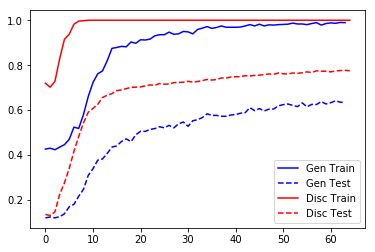

In [209]:
plt.plot(np.asarray(dzstats)[:,1], label="Gen Train", linestyle='-', c="blue")
plt.plot(np.asarray(dzstats)[:,0], label="Gen Test", linestyle='--', c="blue")

plt.plot(np.asarray(zstats)[:,1], label="Disc Train", linestyle='-', c="red")
plt.plot(np.asarray(zstats)[:,0], label="Disc Test", linestyle='--', c="red")

plt.legend()

In [38]:
import h5py
from fuel.converters.base import fill_hdf5_file
from fuel.datasets import SVHN
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme

In [ ]:
#y.shape

In [124]:
64*406

25984

In [180]:
preprocess(*train_stream.get_epoch_iterator().next())[0]

array([[-0.01499099, -0.03380182, -0.03078402, ..., -0.00688451,
        -0.01278257, -0.01968044],
       [-0.01733678, -0.03521392, -0.03306841, ..., -0.00302404,
        -0.01493562, -0.02645339],
       [-0.02067768, -0.0294    , -0.03129628, ..., -0.0003717 ,
        -0.02106036, -0.02181587],
       ..., 
       [-0.0163266 , -0.03312733, -0.034986  , ..., -0.00940088,
        -0.03095791, -0.02540156],
       [-0.01599311, -0.03785766, -0.03534985, ..., -0.00645354,
        -0.02583494, -0.02205506],
       [-0.01648992, -0.03358139, -0.03400288, ..., -0.01057131,
        -0.00384989, -0.02460445]], dtype=float32)

In [206]:

input_x = T.matrix('x')
input_y = T.imatrix('targets')


z_inf,z_feat = x_to_z(gparams, inverse_sigmoid(input_x))

d_val, d_feat = discriminator(dparams, input_x, z_inf)

#get_dz = theano.function([input_x], outputs = [d_feat[0],d_feat[1]])

#preprocess = theano.function([x, y], [output.flatten(ndim=2), y])


#disc
#prepreprocess = theano.function([input_x, input_y], outputs = [T.concatenate([d_feat[0],d_feat[1]], axis=1),input_y])

#disc0
#prepreprocess = theano.function([input_x, input_y], outputs = [d_feat[0],input_y])

#z
#prepreprocess = theano.function([input_x, input_y], outputs = [z_inf,input_y])

#z2
#prepreprocess = theano.function([input_x, input_y], outputs = [z_feat,input_y])


#all
prepreprocess = theano.function([input_x, input_y], outputs = 
                               [T.concatenate([d_feat[0],d_feat[1], z_inf, z_feat], axis=1),input_y])

#both
prepreprocess = theano.function([input_x, input_y], outputs = 
                               [T.concatenate([d_feat[0],d_feat[1], z_inf, z_feat], axis=1),input_y])



# def preprocess(x,y):
#     return prepreprocess(normalize(x).reshape((-1,32*32*3)),y)

def preprocess(x,y):
    return prepreprocess(x.reshape((-1,32*32*3)),y)



turned on injected noise in x->z connection
special thing in D


In [185]:
#train_stream.get_epoch_iterator().next()

In [186]:
#preprocess(*train_stream.get_epoch_iterator().next())[0]

In [187]:
#preprocess2(*train_stream.get_epoch_iterator().next())[0]

In [197]:



h5file = h5py.File("/Tmp/cohenjos/ALI-semisuper-allall", mode='w')

print "train data"
train_set = SVHN(2, which_sets=('train',), sources=('features', 'targets'))
train_stream = DataStream.default_stream(
    train_set,
    iteration_scheme=SequentialScheme(73216, 64))
train_features, train_targets = map(
    np.vstack,
    list(zip(*[preprocess(*batch) for batch in
               train_stream.get_epoch_iterator()])))

print "test data"
test_set = SVHN(2, which_sets=('test',), sources=('features', 'targets'))
test_stream = DataStream.default_stream(
    test_set,
    iteration_scheme=SequentialScheme(25984, 64))
test_features, test_targets = map(
    np.vstack,
    list(zip(*[preprocess(*batch) for batch in
               test_stream.get_epoch_iterator()])))

data = (('train', 'features', train_features),
        ('test', 'features', test_features),
        ('train', 'targets', train_targets),
        ('test', 'targets', test_targets))
fill_hdf5_file(h5file, data)
for i, label in enumerate(('batch', 'feature')):
    h5file['features'].dims[i].label = label
for i, label in enumerate(('batch', 'index')):
    h5file['targets'].dims[i].label = label

h5file.flush()
h5file.close()

train data
test data


In [158]:
h5file.flush()
h5file.close()

In [176]:
data[1][2].shape

(25984, 8192)

In [150]:
data[3][2].shape

(25984, 1)